In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import pymc.gp as gp

# -------------------
# 1. 데이터 준비
# -------------------
df= pd.read_csv('final0623.csv')
tmp_df = df.copy()

n_dates = len(tmp_df)
observed_cases_arr = np.asarray(tmp_df['new_cases'].values, dtype='int32')
infectiousness_local_arr = np.asarray(tmp_df['infectiousness'].values, dtype='float32')
detection_prob_arr = np.clip(np.random.normal(loc=0.8, scale=0.05, size=n_dates), 0.5, 1.0).astype('float32')
valid_arr = np.ones(n_dates, dtype=bool)
time_tensor = np.arange(n_dates)[:, None].astype("float32")
inducing_date_nums = np.linspace(0, n_dates - 1, 15).astype("float32")[:, None]  # inducing points (15개)

# -------------------
# 2. PyMC 모델 정의
# -------------------
with pm.Model() as model:
    # 입력 데이터
    D_t_data = tmp_df['D_t']
    M_t_data = tmp_df['M_t']
    H_t_data = tmp_df['H_t']

    # Prior 설정
    baseline_contact_params = [[2.2, 9, 1.05, 0.687], [0.06, 0.28, 1.68, 0.05]]
    HC = pm.Normal('HC', mu=baseline_contact_params[0][0], sigma=baseline_contact_params[1][0])
    NC = pm.Normal('NC', mu=baseline_contact_params[0][1], sigma=baseline_contact_params[1][1])
    HD = pm.Normal('HD', mu=baseline_contact_params[0][2], sigma=baseline_contact_params[1][2])
    ND = pm.Normal('ND', mu=baseline_contact_params[0][3], sigma=baseline_contact_params[1][3])
    p = pm.Normal('p', mu=0.885, sigma=0.08)
    eta = pm.Normal('eta', mu=0.035, sigma=0.01)
    infectiousdays = pm.Normal('infectiousdays', mu=4.519, sigma=2.892)

    # 관측된 D_t, M_t, H_t
    D_t = pm.Normal('si_t', mu=0, sigma=1, observed=D_t_data)
    M_t = pm.Normal('new_delta', mu=0, sigma=1, observed=M_t_data)
    H_t = pm.Normal('HD_t', mu=0, sigma=1, observed=H_t_data)

    # TP 계산
    household_t = HC * (1 - p ** (infectiousdays * H_t))
    nonhousehold_t = M_t * infectiousdays * (1 - p ** ND) * eta
    no_surv = household_t + nonhousehold_t

    if D_t!=0:
        TP_t = D_t*no_surv
    else:
        TP_t=no_surv    
    # TP = pm.Deterministic('TP', TP_t)
    TP = pm.Deterministic('TP', pm.math.clip(TP_t, 1e-3, 1e6))  # 1e-6 대신 1e-3 권장
    log_TP = pm.math.log(TP)


    # log(TP) 기반 GP prior mean 설정
    log_TP = pm.math.log(TP)
    sigma = pm.TruncatedNormal('sigma', mu=0, sigma=0.5, lower=0)
    var = sigma ** 2
    mu_prior = log_TP - var




    # GP 커널 설정
    lengthscale = pm.Lognormal("lengthscale", mu=3, sigma=1)
    alpha = pm.Lognormal("alpha", mu=3, sigma=1)
    cov = gp.cov.RatQuad(1, ls=lengthscale, alpha=alpha)

    # GP 모델 구성
    gp_latent = gp.Latent(cov_func=cov)
    epsilon_L = gp_latent.prior("epsilon_L", X=time_tensor)
    

    # log_R_eff_local 및 R_eff_local
    log_R_eff_local_t = mu_prior + epsilon_L
    R_eff_local_t = pm.Deterministic("R_eff_local_t", pm.math.exp(log_R_eff_local_t))

    # 기대 감염자 수
    expected_infections = infectiousness_local_arr * R_eff_local_t
    expected_infections_vec = expected_infections[valid_arr]

    # 오버디스퍼전
    sqrt_inv_size = pm.HalfNormal("sqrt_inv_size", sigma=0.2)
    size = 1.0 / pm.math.sqrt(sqrt_inv_size)
    size = pm.math.clip(size, 1e-3, 1e3)

    # 감지율 보정
    prob = 1 / (1 + expected_infections_vec / size)
    detection_prob_vec = detection_prob_arr[valid_arr]
    prob_trunc = 1 / (1 + detection_prob_vec * (1 - prob) / prob)
    prob_trunc = pm.math.clip(prob_trunc, 1e-6, 1 - 1e-6)

    # 관측 데이터 모델링
    obs_cases = observed_cases_arr[valid_arr]
    pm.NegativeBinomial("obs", p=prob_trunc, n=size, observed=obs_cases)

    # 샘플링
    trace = pm.sample(draws=1000, tune=500, chains=4, target_accept=0.95, return_inferencedata=True)



/var/folders/9l/y7rn0rr91k73p0jz0hjkjmy00000gn/T/ipykernel_9393/2705876417.py:19: DtypeWarning: Columns (11,50,54) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_infector = pd.read_csv('/Users/gimsyoni/Desktop/biomathlab/data/infectee_220111.csv',encoding='UTF-8')
/var/folders/9l/y7rn0rr91k73p0jz0hjkjmy00000gn/T/ipykernel_9393/2705876417.py:20: DtypeWarning: Columns (11,50,54) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_infectee = pd.read_csv('/Users/gimsyoni/Desktop/biomathlab/data/infectee_220111.csv',encoding='UTF-8')


Mean of gamma distributions: 4.519251246987614
Standard deviation of gamma distributions: 2.892185869661356
coefficient of variation of gamma distributions: 0.6399701436358939
fi_t: delay
-4018.0    0.0
Name: count, dtype: float64
fi_t: delay
-1096.0    0.0
Name: count, dtype: float64
fi_t: delay
0.0    0.0
Name: count, dtype: float64
fi_t: delay
5.0    0.0
Name: count, dtype: float64
fi_t: delay
3.0     0.333333
20.0    0.000000
Name: count, dtype: float64
fi_t: delay
0.0     0.666667
7.0     0.333333
12.0    0.000000
Name: count, dtype: float64
fi_t: delay
10.0    0.0
Name: count, dtype: float64
fi_t: delay
0.0    0.75
3.0    0.50
7.0    0.25
9.0    0.00
Name: count, dtype: float64
fi_t: delay
0.0    0.8
2.0    0.6
3.0    0.2
5.0    0.0
Name: count, dtype: float64
fi_t: delay
-1.0     0.923077
 0.0     0.846154
 1.0     0.769231
 2.0     0.615385
 3.0     0.384615
 4.0     0.307692
 5.0     0.230769
 6.0     0.153846
 11.0    0.076923
 16.0    0.000000
Name: count, dtype: float64
fi_

/Users/gimsyoni/Desktop/biomathlab/code/tp/lib/python3.9/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains i

In [4]:
az.summary(trace, var_names=["HC", "NC", "HD", "ND", "p", "eta", "RL_t"])


arviz - WARNING - Array contains NaN-value.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
HC,2.200,0.060,2.086,2.313,0.001,0.000,11307.0,2695.0,1.0
NC,8.999,0.277,8.468,9.498,0.003,0.002,11308.0,2778.0,1.0
HD,1.034,1.690,-2.199,4.174,0.016,0.025,11598.0,2836.0,1.0
ND,0.688,0.050,0.596,0.782,0.000,0.000,12423.0,2811.0,1.0
p,0.884,0.082,0.734,1.034,0.001,0.001,13478.0,2566.0,1.0
...,...,...,...,...,...,...,...,...,...
RL_t[689],NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN
RL_t[690],NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN
RL_t[691],NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN
RL_t[692],NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN


In [187]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

# 1. 사후 추정 및 평균
R_eff_samples = trace.posterior["R_eff_local_t"]
mean_R = R_eff_samples.mean(dim=["chain", "draw"]).values
mean_R_smooth = pd.Series(mean_R).rolling(window=10, center=True, min_periods=1).mean()

# 2. HDI 계산
hdi = az.hdi(R_eff_samples, hdi_prob=0.9)


varname = list(hdi.data_vars.keys())[0]  # 변수명 자동 추출
hdi_lower = hdi[varname].sel(hdi='lower').values.flatten()
hdi_lower_smooth = pd.Series(hdi_lower).rolling(window=10, center=True, min_periods=1).mean()
hdi_upper = hdi[varname].sel(hdi='higher').values.flatten()
hdi_upper_smooth = pd.Series(hdi_upper).rolling(window=10, center=True, min_periods=1).mean()

# 3. 날짜 설정 및 변환
dates = tmp_df['date'].values if 'date' in tmp_df.columns else np.arange(len(mean_R))
if not np.issubdtype(dates.dtype, np.datetime64):
    dates = pd.to_datetime(dates, errors='coerce')
dates = np.asarray(dates)

# 4. 시각화
plt.figure(figsize=(12, 5))
plt.fill_between(dates, hdi_lower_smooth, hdi_upper_smooth, alpha=0.3, label="90% HDI", color='skyblue')
plt.plot(dates, mean_R_smooth, label="Mean $R_{eff}$", color='blue')
plt.axhline(1.0, color='red', linestyle='--', label="$R_{eff} = 1$")
plt.title("Time-varying $R_{eff}$ (Local)")
plt.xlabel("Date")
plt.ylabel("$R_{eff}$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: 'R_eff_local_t'

In [188]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

# 1. 사후 추정
R_eff_samples = trace.posterior["R_eff_local_t"]
inf_arr = infectiousness_local_arr[valid_arr][None, None, :]
expected_infections_samples = R_eff_samples * inf_arr

# 2. 평균 및 신뢰구간
expected_mean = expected_infections_samples.mean(dim=("chain", "draw")).values.flatten()
expected_mean_smooth = pd.Series(expected_mean).rolling(window=10, center=True, min_periods=1).mean()

# HDI 계산
hdi = az.hdi(expected_infections_samples, hdi_prob=0.9).to_array()
lower_hdi = hdi.sel(hdi='lower').values.flatten()
lower_hdi_smooth = pd.Series(lower_hdi).rolling(window=10, center=True, min_periods=1).mean()

upper_hdi = hdi.sel(hdi='higher').values.flatten()
upper_hdi_smooth = pd.Series(upper_hdi).rolling(window=10, center=True, min_periods=1).mean()

# 3. 관측값과 날짜
obs_cases = observed_cases_arr[valid_arr]
obs_cases_smooth = pd.Series(obs_cases).rolling(window=10, center=True, min_periods=1).mean()
expected_mean_smooth = pd.Series(expected_mean).rolling(window=10, center=True, min_periods=1).mean()

dates = tmp_df['date'].values[valid_arr] if 'date' in tmp_df.columns else np.arange(len(obs_cases))
if not np.issubdtype(dates.dtype, np.datetime64):
    dates = pd.to_datetime(dates, errors='coerce')
dates = np.asarray(dates)

# 4. 시각화
plt.figure(figsize=(12, 5))
plt.plot(dates, obs_cases_smooth,  color='black', label="Observed cases")
plt.plot(dates, expected_mean_smooth, '--', color='steelblue', label="Predicted (mean)")
plt.fill_between(dates, lower_hdi_smooth, upper_hdi_smooth, color='steelblue', alpha=0.3, label="90% HDI")
plt.xlabel("Date")
plt.ylabel("Number of cases")
plt.title("Observed vs Predicted Infections")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: 'R_eff_local_t'

In [189]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 실제값과 예측값
y_true = obs_cases
y_pred = expected_mean

# MAE
mae = mean_absolute_error(y_true, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# R-squared
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.3f}")


MAE: 351.42
RMSE: 730.10
R-squared: -5.705


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import arviz as az

# TP의 사후 평균과 신뢰구간 계산
tp_samples = trace.posterior['TP']  # shape: (chain, draw, time)
mean_tp = tp_samples.mean(dim=["chain", "draw"]).values.flatten()



hdi_tp = az.hdi(tp_samples, hdi_prob=0.95)
# lower_tp = hdi_tp.sel(hdi='lower').values.flatten()
# upper_tp = hdi_tp.sel(hdi='higher').values.flatten()
# 만약 hdi_tp_data가 Dataset이면 아래처럼 추출
lower_tp = hdi_tp['TP'].sel(hdi='lower').values.flatten()
upper_tp = hdi_tp['TP'].sel(hdi='higher').values.flatten()


mean_tp_smooth = pd.Series(mean_tp).rolling(window=10, center=True, min_periods=1).mean()
lower_tp_smooth = pd.Series(lower_tp).rolling(window=10, center=True, min_periods=1).mean()
upper_tp_smooth = pd.Series(upper_tp).rolling(window=10, center=True, min_periods=1).mean()


# hdi를 덮어쓰지 않도록 변수 이름을 변경
hdi_tp_data = az.hdi(tp_samples, hdi_prob=0.9)

# 날짜 설정
dates = tmp_df['date'].values
if not np.issubdtype(dates.dtype, np.datetime64):
    dates = pd.to_datetime(dates, errors='coerce')

# 시각화
plt.figure(figsize=(12, 5))
plt.fill_between(dates, lower_tp_smooth, upper_tp_smooth, alpha=0.3, label="90% HDI", color='lightgreen')
plt.plot(dates, mean_tp_smooth, label="Mean TP", color='green')
plt.title("Estimated Transmission Potential (TP) over Time")
plt.xlabel("Date")
plt.ylabel("TP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: 'TP'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

# 1. 사후 추정 및 평균
R_eff_samples = trace.posterior["R_eff_local_t"]
mean_R = R_eff_samples.mean(dim=["chain", "draw"]).values
mean_R_smooth = pd.Series(mean_R).rolling(window=10, center=True, min_periods=1).mean()

# 2. HDI 계산
hdi = az.hdi(R_eff_samples, hdi_prob=0.95)


varname = list(hdi.data_vars.keys())[0]  # 변수명 자동 추출
hdi_lower = hdi[varname].sel(hdi='lower').values.flatten()
hdi_lower_smooth = pd.Series(hdi_lower).rolling(window=10, center=True, min_periods=1).mean()
hdi_upper = hdi[varname].sel(hdi='higher').values.flatten()
hdi_upper_smooth = pd.Series(hdi_upper).rolling(window=10, center=True, min_periods=1).mean()

# 3. 날짜 설정 및 변환
dates = tmp_df['date'].values if 'date' in tmp_df.columns else np.arange(len(mean_R))
if not np.issubdtype(dates.dtype, np.datetime64):
    dates = pd.to_datetime(dates, errors='coerce')
dates = np.asarray(dates)

# 4. 시각화
plt.figure(figsize=(12, 5))
plt.fill_between(dates, hdi_lower_smooth, hdi_upper_smooth, alpha=0.3, label="90% HDI", color='skyblue')
plt.plot(dates, mean_R_smooth, label="Mean $R_{eff}$", color='blue')
plt.axhline(1.0, color='red', linestyle='--', label="$R_{eff} = 1$")
plt.title("Time-varying $R_{eff}$ ")
plt.xlabel("Date")
plt.ylabel("$R_{eff}$")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'trace' is not defined

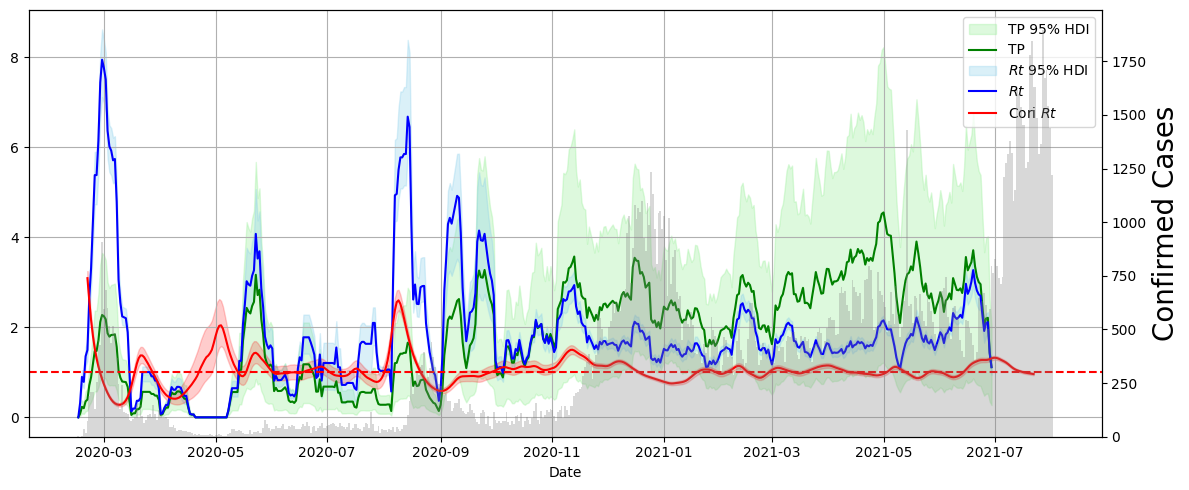

In [192]:
import epyestim
import epyestim.covid19 as covid19


y_si = np.array([0, 0.0422387171440969, 0.186677864336533, 0.204577873537814, 0.161510406462838,
                0.116179573075110, 0.0813863586359072, 0.0568503583671730, 0.0399700264151618,
                0.0283912732868590, 0.0204015777269031, 0.0148344162323375, 0.0109114204164512,
                0.00811469213606264, 0.00609787877070744, 0.00462730812621370, 0.00354367648634868,
                0.00273717403892271, 0.00213126195610691])

# 합계를 1로 정규화
si_distribution = y_si / np.sum(y_si)


# 기존 시각화와 동일한 Figure, Axes 객체 사용
fig, ax = plt.subplots(figsize=(12, 5))

# TP 시각화
ax.fill_between(dates, lower_tp_smooth, upper_tp_smooth, alpha=0.3, label="TP 95% HDI", color='lightgreen')
ax.plot(dates, mean_tp_smooth, label="TP", color='green')

# R_eff 시각화
ax.fill_between(dates, hdi_lower_smooth, hdi_upper_smooth, alpha=0.3, label="$Rt$ 95% HDI", color='skyblue')
ax.plot(dates, mean_R_smooth, label="$Rt$", color='blue')
ax.axhline(1.0, color='red', linestyle='--')

# r_covid 추정치 계산
incidence = df[df['date']<=pd.to_datetime('2021-8')]
tmp = incidence.set_index('date')
r_estimates = covid19.r_covid(
    confirmed_cases=tmp['new_cases'],
    gt_distribution=si_distribution,
)

# r_covid 결과 시각화
ax.plot(r_estimates.index, r_estimates['Q0.5'], color='red', label="Cori $Rt$")
ax.fill_between(r_estimates.index, r_estimates['Q0.025'], r_estimates['Q0.975'], color='red', alpha=0.2)

# 마무리
ax.set_xlabel("Date")
ax.legend()
ax.grid(True)

ax2 = ax.twinx()
ax2.bar(incidence['date'], incidence['new_cases'], color='grey', alpha=0.3, width=1,label='Confirmed Cases')
ax2.set_ylabel('Confirmed Cases', fontsize=20)



fig.tight_layout()
plt.show()


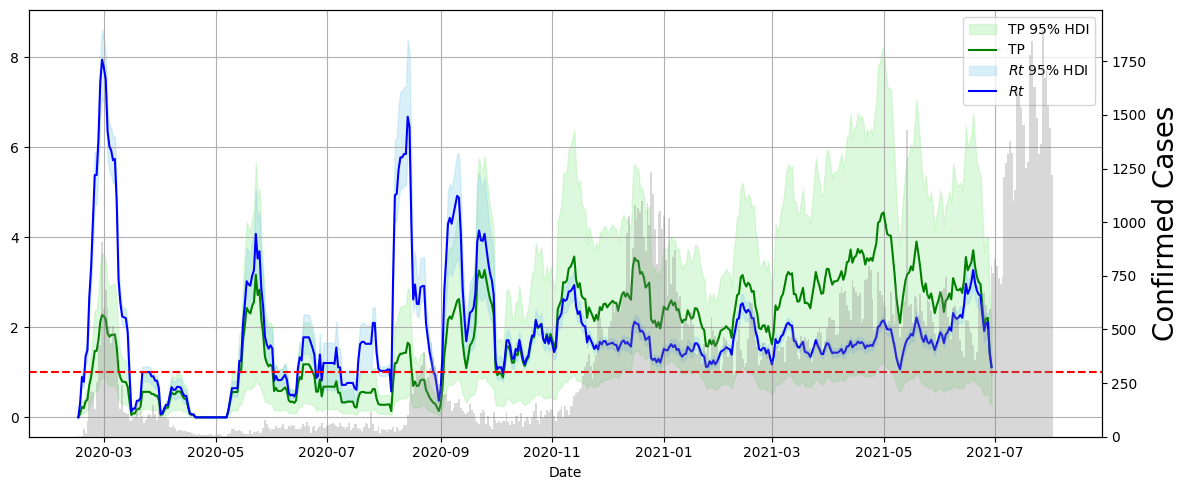

In [ ]:
import epyestim
import epyestim.covid19 as covid19


y_si = np.array([0, 0.0422387171440969, 0.186677864336533, 0.204577873537814, 0.161510406462838,
                0.116179573075110, 0.0813863586359072, 0.0568503583671730, 0.0399700264151618,
                0.0283912732868590, 0.0204015777269031, 0.0148344162323375, 0.0109114204164512,
                0.00811469213606264, 0.00609787877070744, 0.00462730812621370, 0.00354367648634868,
                0.00273717403892271, 0.00213126195610691])

# 합계를 1로 정규화
si_distribution = y_si / np.sum(y_si)


# 기존 시각화와 동일한 Figure, Axes 객체 사용
fig, ax = plt.subplots(figsize=(12, 5))

# TP 시각화
ax.fill_between(dates, lower_tp_smooth, upper_tp_smooth, alpha=0.3, label="TP 95% HDI", color='lightgreen')
ax.plot(dates, mean_tp_smooth, label="TP", color='green')

# R_eff 시각화
ax.fill_between(dates, hdi_lower_smooth, hdi_upper_smooth, alpha=0.3, label="$Rt$ 95% HDI", color='skyblue')
ax.plot(dates, mean_R_smooth, label="$Rt$", color='blue')
ax.axhline(1.0, color='red', linestyle='--')

# r_covid 추정치 계산
incidence = df[df['date']<=pd.to_datetime('2021-8')]
tmp = incidence.set_index('date')
r_estimates = covid19.r_covid(
    confirmed_cases=tmp['new_cases'],
    gt_distribution=si_distribution,
)


# 마무리
ax.set_xlabel("Date")
ax.legend()
ax.grid(True)

ax2 = ax.twinx()
ax2.bar(incidence['date'], incidence['new_cases'], color='grey', alpha=0.3, width=1,label='Confirmed Cases')
# ax2.set_ylabel('Confirmed Cases', fontsize=20)



fig.tight_layout()
plt.show()


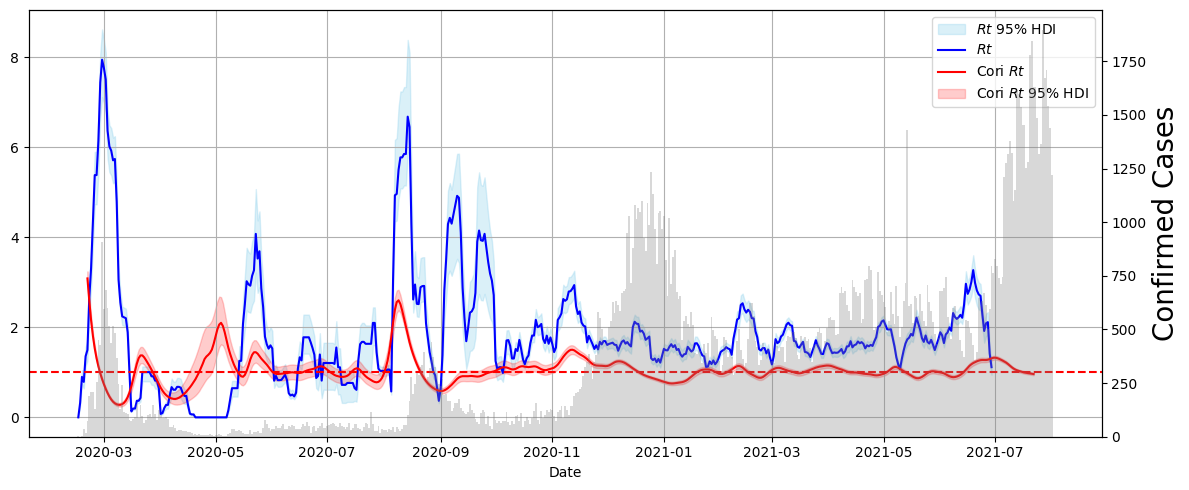

In [180]:
import epyestim
import epyestim.covid19 as covid19


y_si = np.array([0, 0.0422387171440969, 0.186677864336533, 0.204577873537814, 0.161510406462838,
                0.116179573075110, 0.0813863586359072, 0.0568503583671730, 0.0399700264151618,
                0.0283912732868590, 0.0204015777269031, 0.0148344162323375, 0.0109114204164512,
                0.00811469213606264, 0.00609787877070744, 0.00462730812621370, 0.00354367648634868,
                0.00273717403892271, 0.00213126195610691])

# 합계를 1로 정규화
si_distribution = y_si / np.sum(y_si)


# 기존 시각화와 동일한 Figure, Axes 객체 사용
fig, ax = plt.subplots(figsize=(12, 5))


# R_eff 시각화
ax.fill_between(dates, hdi_lower_smooth, hdi_upper_smooth, alpha=0.3, label="$Rt$ 95% HDI", color='skyblue')
ax.plot(dates, mean_R_smooth, label="$Rt$", color='blue')
ax.axhline(1.0, color='red', linestyle='--')

# r_covid 추정치 계산
incidence = df[df['date']<=pd.to_datetime('2021-8')]
tmp = incidence.set_index('date')
r_estimates = covid19.r_covid(
    confirmed_cases=tmp['new_cases'],
    gt_distribution=si_distribution,
)

# r_covid 결과 시각화
ax.plot(r_estimates.index, r_estimates['Q0.5'], color='red', label="Cori $Rt$")
ax.fill_between(r_estimates.index, r_estimates['Q0.025'], r_estimates['Q0.975'], label="Cori $Rt$ 95% HDI",color='red', alpha=0.2)

# 마무리
ax.set_xlabel("Date")
ax.legend()
ax.grid(True)

ax2 = ax.twinx()
ax2.bar(incidence['date'], incidence['new_cases'], color='grey', alpha=0.3, width=1,label='Confirmed Cases')
ax2.set_ylabel('Confirmed Cases', fontsize=20)



fig.tight_layout()
plt.show()
